## Overview
### Pre-Processing:
- Extract ScanImage metadata
- Correct Bi-Directional Offset for each ROI
- Calculates and corrects the MROI seams (IN PROGRESS)
### Motion Correction
- Apply the nonrigid motion correction (NoRMCorre) algorithm for motion correction.
- View pre/most correction movie
- Use quality metrics to evaluate registration quality
### Segmentation
- Apply the constrained nonnegative matrix factorization (CNMF) source separation algorithm to extract initial estimates of neuronal spatial footprints and calcium traces.
- Apply quality control metrics to evaluate the initial estimates, and narrow down to the final set of estimates.

In [1]:
import os
import sys
from pathlib import Path

import cv2
import numpy as np
import pandas as pd

# Give this notebook access to the root package
sys.path.append('../../')  
sys.path.append('../../core/')  

import scanreader

import zarr
import bokeh.plotting as bpl
import holoviews as hv
import panel as pn
from IPython import get_ipython
import logging
import matplotlib.pyplot as plt

try:
    import dask.array as da
    has_dask = True
except ImportError:
    has_dask = False

try:
    cv2.setNumThreads(0)
except():
    pass

# bpl.output_notebook()
# hv.notebook_extension('bokeh')

# logging
logging.basicConfig(format="{asctime} - {levelname} - [{filename} {funcName}() {lineno}] - pid {process} - {message}",
                    filename=None, 
                    level=logging.WARNING, style="{") # this shows you just errors that can harm your program
                    # level=logging.DEBUG, style="{") # this shows you general information that developers use to trakc their program 
                    # (be careful when playing movies, there will be a lot of debug messages)

# set env variables 
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"

# this session had output planes ordered differently, we need to reorder them
chan_order = np.array([ 1, 5, 6, 7, 8, 9, 2, 10, 11, 12, 13, 14, 15, 16, 17, 3, 18, 19, 20, 21, 22, 23, 4, 24, 25, 26, 27, 28, 29, 30])  # this is specific to our dataset
chan_order = [x-1 for x in chan_order]  # convert to 0-based indexing

In [3]:
overwrite = False                                 # flag to re-extract tiffs with extracted data

datapath = Path('C:/Users/RBO/Documents/data/high_res/')   # string pointing to directory containing your data
savepath = Path('C:/Users/RBO/Documents/data/high_res/py_results/')           # string pointing to directory containing your data
savepath.mkdir(exist_ok=True, parents=True)

htiffs = [x for x in datapath.glob('*.tif')]      # this accumulates a list of every filepath which contains a .tif file
htiffs

[WindowsPath('C:/Users/RBO/Documents/data/high_res/MH70_0p6mm_FOV_50_550um_depth_som_stim_199mW_3min_M1_00001_00001.tif')]

In [9]:
reader = scanreader.read_scan(str(htiffs[0]), join_contiguous=True, lbm=True, x_cut=(6,6), y_cut=(17,0))  # this should take < 2s, no actual data is being read yet
data = reader[:, :, :, 1, 1:300].squeeze()
data.shape

(583, 528, 299)

## Scan Phase Correction




### *Methods:*

**1) Linear interpolation**

**2) Phase - cross correlation**


### Phase correction via Linear Phase Interpolation 

In [ ]:
# the 5 pixel-cut looked the best, lets get that one
files = sorted([x for x in savepath.glob("**/*.zarr")])
files[4]

In [ ]:
dataset = files[4]
za = zarr.open(str(dataset))
za.info

In [ ]:
array = da.from_array(za, chunks=za.chunks)
array

## Scan-Phase Correction

Until now our data has been in `int16`. Now that we are performing correlations acrossed averaged pixels, we want a more accurate datatype.
`compute_raster_phase` will load in the data and convert it to a float intrinsically. 

In [ ]:
# WHY IS THIS TAKING SO LONG????
corr = core.util.return_scan_offset(array[:,:,5,400].compute(), 1)
corrected_pc = core.util.fix_scan_phase(array, corr, 1)

## Motion Correction: CaImAn - NORMCorre

Load pre-processed data as a CaImAn `movie`

In [39]:
import caiman as cm
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf import cnmf, params
from caiman.utils.utils import download_demo
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour
from caiman.utils.visualization import view_quilt

Before motion correction, lets see what volumes look like interactively:

In [28]:
data_plane = data_plane.squeeze()

In [29]:
# @pn.cache
# def get_plot_plane(plane=1, frame=1, title=""):
#     return hv.Image(data_plane[:,:, plane,frame]).opts(
#                 width=600,
#                 height=600,
#                 title=f"{title}",
#                 tools=['wheel_zoom'],
#                 cmap='gray', 
#             )

# # Widgets
# plane_slider = pn.widgets.IntSlider(name="plane: ", value=1, start=1, end=9)
# frame_slider = pn.widgets.IntSlider(name="frame: ", value=1, start=1, end=9)

# bound_plot = pn.bind(get_plot_plane, frame=frame_slider, plane=plane_slider) 

# # Layout of widgets and plot
# layout = pn.Column(
#     pn.Row(plane_slider, width=200),
#     pn.Row(frame_slider, width=200),
#     bound_plot
# )

# # Display the layout
# layout.servable()

Column
    [0] Row(width=200)
        [0] IntSlider(end=9, name='plane: ', start=1, value=1)
    [1] Row(width=200)
        [0] IntSlider(end=9, name='frame: ', start=1, value=1)
    [2] ParamFunction(function, _pane=HoloViews, defer_load=False)

## Correlation metrics

Create a couple of summary images of the movie, including:
- maximum projection (the maximum value of each pixel) 
- correlation image (how correlated each pixel is with its neighbors)

If a pixel comes from an active neural component it will tend to be highly correlated with its neighbors.

In [36]:
data_plane.shape

(583, 528, 30, 1730)

In [46]:
max_projection = np.max(data_plane[:,:, -1,:], axis=0)
max_projection.shape

(528, 1730)

In [48]:
correlation_image = cm.local_correlations(data_plane[:,:,-1,1:4], swap_dim=False)
correlation_image[np.isnan(correlation_image)] = 0

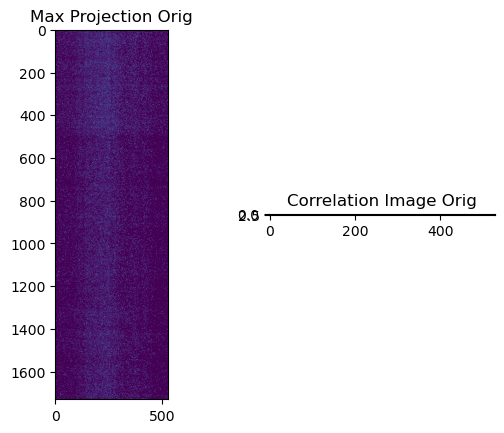

In [49]:
%matplotlib inline
f, (ax_max, ax_corr) = plt.subplots(1,2)
ax_max.imshow(max_projection.T, 
              cmap='viridis',
              vmin=np.percentile(np.ravel(max_projection),50), 
              vmax=np.percentile(np.ravel(max_projection),99.5));
ax_max.set_title("Max Projection Orig", fontsize=12)
ax_corr.imshow(correlation_image.T, 
               cmap='viridis', 
               vmin=np.percentile(np.ravel(correlation_image),50), 
               vmax=np.percentile(np.ravel(correlation_image),99.5))
ax_corr.set_title('Correlation Image Orig', fontsize=12)
plt.show()

### Parameter Selection

In [50]:
max_shifts = (6, 6)  # maximum allowed rigid shift in pixels (view the movie to get a sense of motion)
strides =  (48, 48)  # create a new patch every x pixels for pw-rigid correction
overlaps = (24, 24)  # overlap between patches (size of patch strides+overlaps)
max_deviation_rigid = 3   # maximum deviation allowed for patch with respect to rigid shifts
pw_rigid = False  # flag for performing rigid or piecewise rigid motion correction
shifts_opencv = True  # flag for correcting motion using bicubic interpolation (otherwise FFT interpolation is used)
border_nan = 'copy'  # replicate values along the boundary (if True, fill in with NaN)

In [ ]:
file_in = [x for x in savepath.glob("*.zarr")]
file_in[0]

## Save as a tiff, for now 

TODO: why is caiman not recognizing the zarr group?

In [ ]:
import tifffile
fpath = Path('/data2/fpo/data/raw/raw.tiff')
fpath.exists()
    
data_plane = data[:,:,5,2:1002]
data_plane = data_plane.reshape((data_plane.shape[-1], data_plane.shape[0], data_plane.shape[1]))
tifffile.imwrite(fpath, data_plane)

In [ ]:
my_data = zarr.open('/data2/fpo/data/extracted/high_res/high_res.zarr')

In [ ]:
##%% start the cluster (if a cluster already exists terminate it)
if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='multiprocessing', n_processes=None, single_thread=False)
# create a motion correction object

mc = MotionCorrect(str(fpath), dview=dview, max_shifts=max_shifts,
                  strides=strides, overlaps=overlaps,
                  max_deviation_rigid=max_deviation_rigid, 
                  shifts_opencv=shifts_opencv, nonneg_movie=True,
                  border_nan=border_nan)


In [ ]:
%%capture
# correct for rigid motion correction and save the file (in memory mapped form)
mc.motion_correct(save_movie=True)

### View rigid template

In [ ]:
# load motion corrected movie
m_rig = cm.load(mc.mmap_file)
bord_px_rig = np.ceil(np.max(mc.shifts_rig)).astype(int)
##%% visualize templates
plt.figure(figsize = (20,10))
plt.imshow(mc.total_template_rig, cmap = 'gray');

Rigid-corrected movie

In [ ]:
##%% inspect movie
m_rig.resize(1, 1, downsample_ratio).play(
    q_max=99.5, fr=30, magnification=2, bord_px = 0*bord_px_rig) # press q to exit

Rigid Template shifts

In [ ]:
##%% plot rigid shifts
plt.close()
plt.figure(figsize = (20,10))
plt.plot(mc.shifts_rig)
plt.legend(['x shifts','y shifts'])
plt.xlabel('frames')
plt.ylabel('pixels');


## Piecewise rigid registration

While rigid registration corrected for a lot of the movement, there is still non-uniform motion present in the registered file.

- To correct for that we can use piece-wise rigid registration directly in the original file by setting mc.pw_rigid=True.
- As before the registered file is saved in a memory mapped format in the location given by mc.mmap_file.


In [ ]:
%%capture
##%% motion correct piecewise rigid
mc.pw_rigid = True  # turn the flag to True for pw-rigid motion correction
mc.template = mc.mmap_file  # use the template obtained before to save in computation (optional)

mc.motion_correct(save_movie=True, template=mc.total_template_rig)
m_els = cm.load(mc.fname_tot_els)
m_els.resize(1, 1, downsample_ratio).play(
    q_max=99.5, fr=30, magnification=2,bord_px = bord_px_rig)

visualize non-rigid shifts for the entire FOV

TODO: Interactively visualize rigid+non-rigid shifts independantly

In [ ]:
plt.close()
plt.figure(figsize = (20,10))
plt.subplot(2, 1, 1)
plt.plot(mc.x_shifts_els)
plt.ylabel('x shifts (pixels)')
plt.subplot(2, 1, 2)
plt.plot(mc.y_shifts_els)
plt.ylabel('y_shifts (pixels)')
plt.xlabel('frames')
##%% compute borders to exclude
bord_px_els = np.ceil(np.maximum(np.max(np.abs(mc.x_shifts_els)),
                                 np.max(np.abs(mc.y_shifts_els)))).astype(int)

## Motion Corretion: Optical Flow

In [ ]:
##%% plot the results of Residual Optical Flow
fls = [cm.paths.fname_derived_presuffix(mc.fname_tot_els[0], 'metrics', swapsuffix='npz'),
       cm.paths.fname_derived_presuffix(mc.fname_tot_rig[0], 'metrics', swapsuffix='npz'),
       cm.paths.fname_derived_presuffix(mc.fname[0],         'metrics', swapsuffix='npz'),
      ]

plt.figure(figsize = (20,10))
for cnt, fl, metr in zip(range(len(fls)), fls, ['pw_rigid','rigid','raw']):
    with np.load(fl) as ld:
        print(ld.keys())
        print(fl)
        print(str(np.mean(ld['norms'])) + '+/-' + str(np.std(ld['norms'])) +
              ' ; ' + str(ld['smoothness']) + ' ; ' + str(ld['smoothness_corr']))
        
        plt.subplot(len(fls), 3, 1 + 3 * cnt)
        plt.ylabel(metr)
        print(f"Loading data with base {fl[:-12]}")
        try:
            mean_img = np.mean(
            cm.load(fl[:-12] + '.mmap'), 0)[12:-12, 12:-12]
        except:
            try:
                mean_img = np.mean(
                    cm.load(fl[:-12] + '.tif'), 0)[12:-12, 12:-12]
            except:
                mean_img = np.mean(
                    cm.load(fl[:-12] + 'hdf5'), 0)[12:-12, 12:-12]
                    
        lq, hq = np.nanpercentile(mean_img, [.5, 99.5])
        plt.imshow(mean_img, vmin=lq, vmax=hq)
        plt.title('Mean')
        plt.subplot(len(fls), 3, 3 * cnt + 2)
        plt.imshow(ld['img_corr'], vmin=0, vmax=.35)
        plt.title('Corr image')
        plt.subplot(len(fls), 3, 3 * cnt + 3)
        flows = ld['flows']
        plt.imshow(np.mean(
        np.sqrt(flows[:, :, :, 0]**2 + flows[:, :, :, 1]**2), 0), vmin=0, vmax=0.3)
        plt.colorbar()
        plt.title('Mean optical flow');  

# Cleanup

Make sure our parallel cluster is shut down.

In [ ]:
if 'dview' in locals():
    cm.stop_server(dview=dview)
elif 'cluster' in locals():
    cm.stop_server(dview=cluster)